In [4]:
import pandas as pd
import pickle
import os
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
path_to_processed_dataset_folder = '/home/shoaib/gnn/gcn/datasets'

In [6]:
if os.path.exists(path_to_processed_dataset_folder):
  print("Directory exists")
else:
  print("Directory not exists")

Directory exists


In [7]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils import add_self_loops, coalesce
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.utils import index_to_mask
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [8]:
torch.manual_seed(0)
np.random.seed(0)

In [13]:
# Read the CSV files into DataFrames
user_df = pd.read_csv(f'{path_to_processed_dataset_folder}/user_features_processed.csv', header = 0)
news_df = pd.read_csv(f'{path_to_processed_dataset_folder}/news_features_processed.csv', header = 0)

# Remove duplicates based on the first column
user_df = user_df.drop_duplicates(subset=[user_df.columns[0]])
news_df = news_df.drop_duplicates(subset=[news_df.columns[0]])

In [14]:
# Load user and news features, excluding the first column
user_features = user_df.values[:, 1:]
news_features = news_df.values[:, 1:]

In [15]:
# Get the usernames and newsnames
usernames = user_df.values[:, 0]
newsnames = news_df.values[:, 0]

# Create the username_to_index and newsname_to_index dictionaries
username_to_index = {username: index for index, username in enumerate(usernames)}
newsname_to_index = {filename: index + len(usernames) for index, filename in enumerate(newsnames)}

In [16]:
# Read the relationship file into a DataFrame
relationship_df = pd.read_csv(f'{path_to_processed_dataset_folder}/relationship_user_and_news_v2.csv')

# Remove duplicates based on the username
relationship_df = relationship_df.drop_duplicates(subset=['username'])

In [17]:
relationship_df

,username,filename,label,human_evaluation
0,JcKatherine,politifact13816,0.0,4
1,bjr1961,politifact13816,0.0,4
2,SherryAva,politifact13816,0.0,4
3,linnflux,politifact13816,0.0,4
4,po_murray,politifact13816,0.0,4
...,...,...,...,...
14530,Omwenga,politifact12721,1.0,3
14531,MarkPaleo,politifact12721,1.0,3
14532,einerdrake,politifact12721,1.0,4
14533,Corinne4Hillary,politifact12721,1.0,5


In [18]:
# Create adjacency matrix

#calculates the total number of nodes in the graph, which is the sum of the number of users (len(usernames)) and the number of news items (len(newsnames)).
num_nodes = len(usernames) + len(newsnames)

"""
initializes an adjacency matrix as a 2D NumPy array of zeros with shape (num_nodes, num_nodes).
This creates a square matrix with dimensions equal to the total number of nodes in the graph.
The matrix is initially filled with zeros, indicating that there are no edges between any pair of nodes.
"""

adjacency_matrix = np.zeros((num_nodes, num_nodes))

"""
iterates over the rows of the relationship_df DataFrame, which contains the relationships between users 
and news items. For each row, it gets the indices of the user and the news item in the username_to_index and newsname_to_index 
dictionaries, respectively. These indices correspond to the positions of the user and the news item in the adjacency matrix.
Finally, it sets the element of the adjacency matrix at the position (user_id, news_id) to 1, indicating that there is 
an edge between the user and the news item. This is done for every row in the relationship_df DataFrame, effectively filling 
in the adjacency matrix with the relationships between users and news items.
At the end of this code block, adjacency_matrix is a 2D NumPy array that represents the graph of users and news items. If there 
is a relationship between a user and a news item, the corresponding element in the adjacency matrix is 1; otherwise, it is 0.
"""

for _, row in relationship_df.iterrows():
    user_id = username_to_index[row['username']]
    news_id = newsname_to_index[row['filename']]
    adjacency_matrix[user_id, news_id] = 1



In [19]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
# Initialize the edge attribute matrix with zeros
edge_attr_matrix = np.zeros((num_nodes, num_nodes))

# Fill the edge attribute matrix with human survey values
for _, row in relationship_df.iterrows():
    user_id = username_to_index[row['username']]
    news_id = newsname_to_index[row['filename']]
    survey_value = row['human_evaluation'] 
    edge_attr_matrix[user_id, news_id] = survey_value

# Convert the edge attribute matrix into a tensor
edge_attr_matrix = np.eye(num_nodes) + edge_attr_matrix  # Add self-loops
edge_attr = torch.tensor(edge_attr_matrix[edge_attr_matrix.nonzero()], dtype=torch.float)

In [23]:
# Load node attributes, adjacency matrix, and labels from .npy files
node_attributes = np.load(f'{path_to_processed_dataset_folder}/node_attributes.npy', allow_pickle = True)
adj = np.load(f'{path_to_processed_dataset_folder}/adjacency_matrix.npy', allow_pickle = True)
y = np.load(f'{path_to_processed_dataset_folder}/labels_v2.npy', allow_pickle = True)

In [24]:
node_attributes

array([[1.27, 11122.0, 11272.0, ..., 0.0, 0.0, 0.0],
       [1.06, 267.0, 1359.0, ..., 0.0, 0.0, 0.0],
       [1.33, 537.0, 409.0, ..., 0.0, 0.0, 0.0],
       ...,
       [14.511231890100216, 47.83230057107836, 14.0091382248733, ...,
        1.42, 0.94, 0.24],
       [13.5591, 45.29501831501835, 14.264175824175828, ..., 0.0, 0.0,
        1.01],
       [12.254254345995212, 61.67082158675014, 10.53875914973744, ...,
        1.4, 0.06, 2.02]], dtype=object)

In [25]:
# Check if all nodes have self-loops
has_self_loops = np.all(np.diag(adjacency_matrix) == 1)
print('All nodes have self-loops:', has_self_loops)

All nodes have self-loops: False


In [26]:
# Convert adjacency matrix to edge index
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)

# Convert node attributes to tensor
node_attributes = node_attributes.astype(np.float32)
x = torch.from_numpy(node_attributes).to(torch.float)

# Add self loops to the edge index
edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

# Coalesce the edge index
num_nodes = x.size(0)
edge_index, _ = coalesce(edge_index, None, num_nodes, num_nodes)

# Convert labels to tensor and pad with zeros
y = torch.from_numpy(y.squeeze()).to(torch.long)
#y = torch.cat((y, torch.zeros(num_nodes - y.size()[0], dtype=torch.long)))

# Create Data object
data = Data(x=x, edge_index=edge_index, edge_attr = edge_attr, y=y)

In [27]:
print(edge_index)
print(len(edge_index))
print(edge_index.shape[1])

tensor([[    0,     0,     1,  ..., 13337, 13338, 13339],
        [    0, 13202,     1,  ..., 13337, 13338, 13339]])
2
26494


In [28]:
print(edge_attr.shape[0])

26494


In [29]:
y.shape

torch.Size([13340])

In [133]:
y.size

<function Tensor.size>

In [30]:
x.size(1)

138

In [31]:
edge_index.shape

torch.Size([2, 26494])

In [32]:
train_per = 0.8  # Adjust as needed

y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(range(y.size), y.squeeze(),
                                                    test_size=1 - train_per - 0.1, random_state=41)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=train_per / (train_per + 0.1), random_state=42)

train_index = torch.tensor(X_train, dtype=torch.long)
val_index = torch.tensor(X_val, dtype=torch.long)
test_index = torch.tensor(X_test, dtype=torch.long)

train_mask = index_to_mask(train_index, size=num_nodes)
val_mask = index_to_mask(val_index, size=num_nodes)
test_mask = index_to_mask(test_index, size=num_nodes)

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [33]:
print(y)

[2 2 2 ... 1 1 1]


In [34]:
print(edge_index.size())
print(edge_attr.size())

torch.Size([2, 26494])
torch.Size([26494])


In [45]:
from torch_geometric.nn import GATConv, BatchNorm
from torch_geometric.utils import add_self_loops, degree
from torch_scatter import scatter_add

class EdgeAttrGATConv(GATConv):
    def __init__(self, in_channels, out_channels, heads=1, **kwargs):
        super(EdgeAttrGATConv, self).__init__(in_channels, out_channels, heads=heads, **kwargs)

    def forward(self, x, edge_index, edge_attr):
        # Add self-loops to the adjacency matrix
        edge_index, edge_attr = add_self_loops(edge_index, edge_attr, num_nodes=x.size(0))

        # Compute the degree of each node
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)

        # Divide each edge attribute by the square root of the degree of its nodes
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        edge_attr_norm = edge_attr * deg_inv_sqrt[row] * deg_inv_sqrt[col]
        edge_attr_sum = scatter_add(edge_attr_norm, row, dim=0, dim_size=x.size(0))
        x = x * edge_attr_sum.view(-1, 1)

        # Original forward pass
        out = super().forward(x, edge_index)

        return out
    
class GATModel(torch.nn.Module):
    def __init__(self, num_features, num_classes, dropout=0.5, heads=4):
        super(GATModel, self).__init__()
        self.dropout = dropout
        self.conv1 = EdgeAttrGATConv(num_features, 64, heads=heads)
        self.bn1 = BatchNorm(64 * heads)  # Batch normalization after the first layer
        self.conv2 = EdgeAttrGATConv(64 * heads, num_classes, heads=1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # First GAT layer with dropout and batch normalization
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.bn1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second GAT layer
        x = self.conv2(x, edge_index, edge_attr)

        return F.log_softmax(x, dim=-1)

In [46]:
num_classes = len(np.unique(y))  # Adjust as needed
num_classes

3

In [52]:

model = GATModel(num_features=x.size(1), num_classes=num_classes, dropout=0.5, heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

In [53]:
# loss function optimization considering the only two classes 

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    
    # Create a mask for the fake and real news
    news_mask = (data.y[data.train_mask] == 0) | (data.y[data.train_mask] == 1)
    
    # Apply the mask to the output and labels
    out_news = out[data.train_mask][news_mask]
    labels_news = data.y[data.train_mask][news_mask]
    
    # Compute the loss only for the fake and real news
    loss = F.nll_loss(out_news, labels_news)
    
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]
        
        # Create a mask for the fake and real news
        news_mask = (data.y[mask] == 0) | (data.y[mask] == 1)
        
        # Apply the mask to the predictions and labels
        preds_news = preds[mask][news_mask]
        labels_news = data.y[mask][news_mask]
        
        correct = preds_news.eq(labels_news).sum().item()
        acc = correct / news_mask.sum().item()
        return acc, preds_news, labels_news


In [54]:
# Best accuracy from epochs

best_acc = 0.0
best_epoch = 0
best_state_dict = None
patience = 100  # Number of epochs to wait for improvement before stopping
wait = 0

for epoch in range(1, 500):
    loss = train()
    train_acc, _, _ = test(data.train_mask)
    val_acc, _, _ = test(data.val_mask)
    test_acc, preds, labels = test(data.test_mask)
    
    # Save the model parameters if this epoch has the best accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        best_state_dict = model.state_dict()
        wait = 0  # Reset the counter
    else:
        wait += 1  # Increment the counter if no improvement
    
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Stop training if no improvement for 'patience' epochs
    if wait >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

print(f'Best Val Acc: {best_acc} at Epoch: {best_epoch}')

Epoch: 1, Loss: 2.6658, Train Acc: 0.5000, Val Acc: 0.4966, Test Acc: 0.4737
Epoch: 2, Loss: 2.3667, Train Acc: 0.5000, Val Acc: 0.4897, Test Acc: 0.4211
Epoch: 3, Loss: 3.2221, Train Acc: 0.5068, Val Acc: 0.5034, Test Acc: 0.4737
Epoch: 4, Loss: 1.6459, Train Acc: 0.5473, Val Acc: 0.5448, Test Acc: 0.5526
Epoch: 5, Loss: 1.4592, Train Acc: 0.5676, Val Acc: 0.5724, Test Acc: 0.6053
Epoch: 6, Loss: 1.7352, Train Acc: 0.6081, Val Acc: 0.5931, Test Acc: 0.5789
Epoch: 7, Loss: 1.8191, Train Acc: 0.6216, Val Acc: 0.6276, Test Acc: 0.6316
Epoch: 8, Loss: 1.1928, Train Acc: 0.6351, Val Acc: 0.6483, Test Acc: 0.6579
Epoch: 9, Loss: 1.3775, Train Acc: 0.6351, Val Acc: 0.6690, Test Acc: 0.7632
Epoch: 10, Loss: 1.3748, Train Acc: 0.6284, Val Acc: 0.6759, Test Acc: 0.7895
Epoch: 11, Loss: 1.0160, Train Acc: 0.6351, Val Acc: 0.6759, Test Acc: 0.7895
Epoch: 12, Loss: 1.5811, Train Acc: 0.6554, Val Acc: 0.6897, Test Acc: 0.7895
Epoch: 13, Loss: 0.8172, Train Acc: 0.6554, Val Acc: 0.6897, Test Acc: 0.

In [55]:
path_to_saved_model_folder = '/home/shoaib/gnn/gcn/saved-models'
model_name = 'gat_model_human_evaluation_v2'
path = f'{path_to_saved_model_folder}/{model_name}.pth'

torch.save(best_state_dict, path)

Fold 1 Test Accuracy: 0.8378378378378378
Fold 1 Test F1 Score: 0.8342181467181468
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       0.75      1.00      0.86        18

    accuracy                           0.84        37
   macro avg       0.88      0.84      0.83        37
weighted avg       0.88      0.84      0.83        37



<ipython-input-56-5be89f4d1aed>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


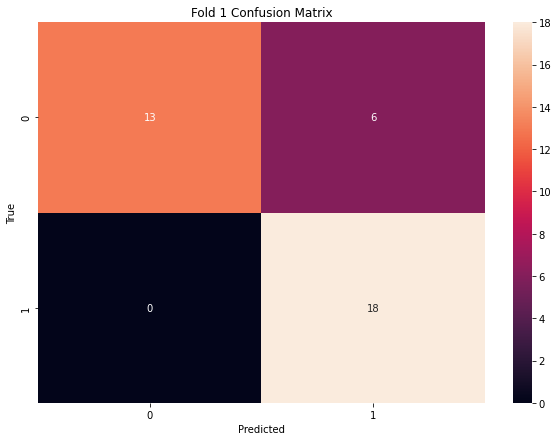

<ipython-input-56-5be89f4d1aed>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Fold 2 Test Accuracy: 0.7567567567567568
Fold 2 Test F1 Score: 0.7531611434050458
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        19
           1       0.70      0.89      0.78        18

    accuracy                           0.76        37
   macro avg       0.78      0.76      0.75        37
weighted avg       0.78      0.76      0.75        37



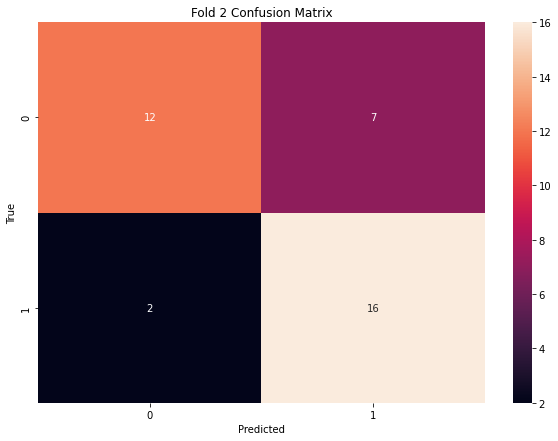

<ipython-input-56-5be89f4d1aed>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Fold 3 Test Accuracy: 0.7297297297297297
Fold 3 Test F1 Score: 0.7273449920508743
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.63      0.71        19
           1       0.68      0.83      0.75        18

    accuracy                           0.73        37
   macro avg       0.74      0.73      0.73        37
weighted avg       0.74      0.73      0.73        37



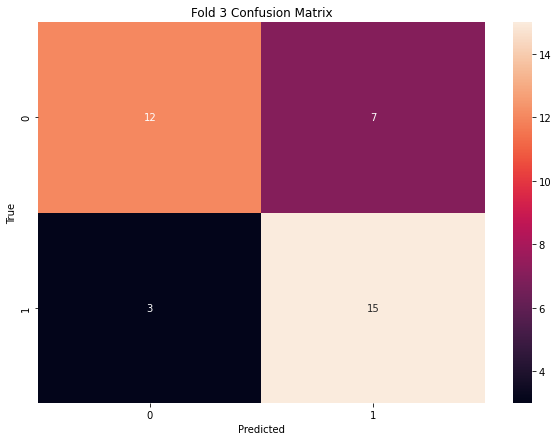

Fold 4 Test Accuracy: 0.8918918918918919
Fold 4 Test F1 Score: 0.8915757863126285
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.81      1.00      0.89        17

    accuracy                           0.89        37
   macro avg       0.90      0.90      0.89        37
weighted avg       0.91      0.89      0.89        37



<ipython-input-56-5be89f4d1aed>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


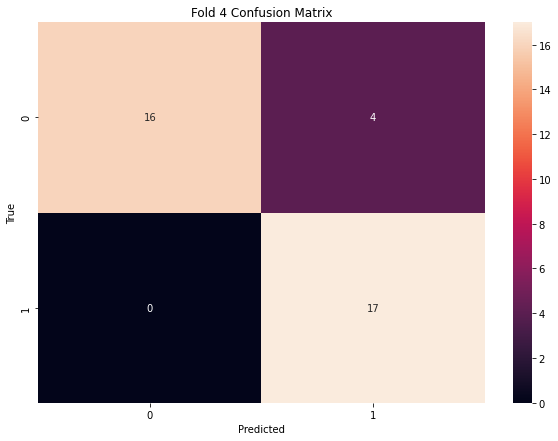

Fold 5 Test Accuracy: 0.7105263157894737
Fold 5 Test F1 Score: 0.7075004584632313
Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.60      0.69        20
           1       0.65      0.83      0.73        18

    accuracy                           0.71        38
   macro avg       0.73      0.72      0.71        38
weighted avg       0.73      0.71      0.71        38



<ipython-input-56-5be89f4d1aed>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


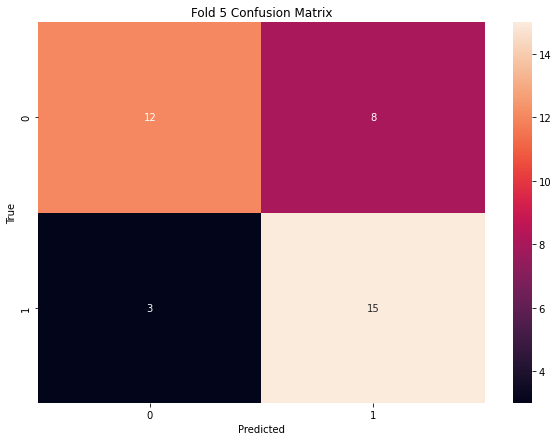

Average Test Accuracy: 0.7853485064011381
Average Test F1 Score: 0.7827601053899853


In [56]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Initialize lists to store the accuracy and F1 score for each fold
accuracy_scores = []
f1_scores = []

# Perform cross-validation
for i, (train_index, test_index) in enumerate(cv.split(np.zeros(len(y)), y), start=1):
    # Split the data into training and test sets
    data.train_mask = index_to_mask(torch.tensor(train_index), size=num_nodes)
    data.test_mask = index_to_mask(torch.tensor(test_index), size=num_nodes)

    # Load the best model
    model.load_state_dict(torch.load(path))

    # Predictions with the best model
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]

    # # Check for unexpected class labels
    # unique_preds = torch.unique(preds)
    # if len(unique_preds) > 2 or (unique_preds != 0).any() or (unique_preds != 1).any():
    #     print(f'Unexpected class labels in fold {i}: {unique_preds}')
    #     continue

    # Create a mask for the fake and real news
    news_mask = ((data.y == 0) | (data.y == 1)) & data.test_mask

    # Apply the news mask to the labels and predictions
    labels_news = data.y[news_mask]
    preds_news = preds[news_mask]

    # Print the unique values in the labels and predictions
    # print(f'Unique labels: {torch.unique(labels_news)}')
    # print(f'Unique predictions: {torch.unique(preds_news)}')

    # Compute the accuracy and F1 score
    accuracy = accuracy_score(labels_news.cpu(), preds_news.cpu())
    f1 = f1_score(labels_news.cpu(), preds_news.cpu(), average='weighted')

    # Store the accuracy and F1 score
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f'Fold {i} Test Accuracy: {accuracy}')
    print(f'Fold {i} Test F1 Score: {f1}')

    report = classification_report(labels_news.cpu(), preds_news.cpu())
    print(f'Fold {i} Classification Report:')
    print(report)

    cm = confusion_matrix(labels_news.cpu(), preds_news.cpu())

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {i} Confusion Matrix')
    plt.show()

# Compute the average accuracy and F1 score
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Test Accuracy: {average_accuracy}')
print(f'Average Test F1 Score: {average_f1}')

The effect of changing the number of output channels (or the number of attention heads in the case of GAT) can indeed depend on the specific characteristics of the data and task. In this case, the edge attributes seem to play a significant role.


1. **Importance of edge attributes**: In some graph-structured data, the attributes of the edges can carry significant information for the task at hand. If this is the case, a model that can effectively leverage this information might perform better. When include edge attributes in the model, the model has more information to learn from, and thus, the complexity of the model (i.e., the number of attention heads) might have a more noticeable effect on the performance.

2. **Interaction between node features and edge attributes**: In this custom GATConv layer, modifying the node features based on the edge attributes before passing them through the GATConv layer. This creates an interaction between the node features and the edge attributes. The number of attention heads in the GATConv layer determines how these modified node features are processed. Therefore, changing the number of attention heads can have a significant effect on how the model leverages the edge attributes.

3. **Model capacity**: When need to include edge attributes, the model has more information to learn from. This increases the capacity needed by the model to learn effectively from the data. Reducing the number of attention heads might be reducing the model's capacity to a level that's more appropriate for the amount and complexity of information it has to learn from.